# Path Integral Monte Carlo (PIMC)

## Theoretical Foundation

Path Integral Monte Carlo is a powerful computational technique for studying quantum many-body systems at finite temperature. It is based on Richard Feynman's path integral formulation of quantum mechanics, which recasts quantum statistical mechanics as a classical problem in an extended configuration space.

### The Density Matrix and Partition Function

The central quantity in quantum statistical mechanics is the canonical partition function:

$$Z = \text{Tr}[e^{-\beta \hat{H}}] = \int dx \, \langle x | e^{-\beta \hat{H}} | x \rangle$$

where $\beta = 1/(k_B T)$ is the inverse temperature and $\hat{H}$ is the Hamiltonian operator. The diagonal elements of the density matrix $\rho(x, x; \beta) = \langle x | e^{-\beta \hat{H}} | x \rangle$ give the probability distribution for finding the system at position $x$.

### Trotter-Suzuki Decomposition

For a Hamiltonian $\hat{H} = \hat{T} + \hat{V}$ (kinetic + potential), the key challenge is that $\hat{T}$ and $\hat{V}$ do not commute. We use the Trotter-Suzuki decomposition:

$$e^{-\beta \hat{H}} = \left( e^{-\tau \hat{H}} \right)^M \approx \left( e^{-\tau \hat{T}} e^{-\tau \hat{V}} \right)^M + O(\tau^2)$$

where $\tau = \beta/M$ is the imaginary time step and $M$ is the number of time slices (Trotter number).

### Path Integral Representation

Inserting complete sets of position states between each factor, we obtain:

$$Z = \int dx_0 \, dx_1 \cdots dx_{M-1} \prod_{i=0}^{M-1} \langle x_i | e^{-\tau \hat{T}} | x_{i+1} \rangle e^{-\tau V(x_i)}$$

with periodic boundary condition $x_M = x_0$. The free-particle propagator is:

$$\langle x_i | e^{-\tau \hat{T}} | x_{i+1} \rangle = \sqrt{\frac{m}{2\pi\hbar^2\tau}} \exp\left( -\frac{m(x_i - x_{i+1})^2}{2\hbar^2\tau} \right)$$

### Effective Classical Action

The partition function can be written as:

$$Z = \int \mathcal{D}[x] \, e^{-S[x]/\hbar}$$

where the discretized Euclidean action is:

$$S[x] = \sum_{i=0}^{M-1} \left[ \frac{m(x_i - x_{i+1})^2}{2\tau} + \tau V(x_i) \right]$$

This maps the quantum problem onto a classical ring polymer with $M$ beads connected by harmonic springs!

### Monte Carlo Sampling

We sample configurations from the Boltzmann distribution $P[x] \propto e^{-S[x]/\hbar}$ using the Metropolis-Hastings algorithm:

1. Propose a move: $x_i \to x_i'$
2. Calculate action change: $\Delta S = S[x'] - S[x]$
3. Accept with probability: $\min(1, e^{-\Delta S/\hbar})$

### Observables

The expectation value of an observable $\hat{O}$ is:

$$\langle \hat{O} \rangle = \frac{1}{Z} \text{Tr}[\hat{O} e^{-\beta \hat{H}}]$$

For diagonal operators like $V(x)$, we average over the path:

$$\langle V \rangle = \left\langle \frac{1}{M} \sum_{i=0}^{M-1} V(x_i) \right\rangle_{\text{MC}}$$

The kinetic energy estimator (virial form) is:

$$\langle T \rangle = \frac{1}{2\beta} - \left\langle \frac{1}{2M} \sum_{i=0}^{M-1} (x_i - \bar{x}) \frac{\partial V}{\partial x_i} \right\rangle_{\text{MC}}$$

where $\bar{x} = \frac{1}{M}\sum_i x_i$ is the centroid.

## Implementation: Quantum Harmonic Oscillator

We will apply PIMC to the quantum harmonic oscillator:

$$V(x) = \frac{1}{2} m \omega^2 x^2$$

This system has exact analytical solutions, making it ideal for validation:

- Ground state energy: $E_0 = \frac{1}{2}\hbar\omega$
- Energy at temperature $T$: $\langle E \rangle = \hbar\omega \left( \frac{1}{2} + \frac{1}{e^{\beta\hbar\omega} - 1} \right)$
- Position variance: $\langle x^2 \rangle = \frac{\hbar}{2m\omega} \coth\left(\frac{\beta\hbar\omega}{2}\right)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Natural units: hbar = m = omega = 1
hbar = 1.0
m = 1.0
omega = 1.0

In [2]:
def harmonic_potential(x):
    """Harmonic oscillator potential V(x) = 0.5 * m * omega^2 * x^2"""
    return 0.5 * m * omega**2 * x**2

def harmonic_force(x):
    """Force from harmonic potential: F = -dV/dx = -m * omega^2 * x"""
    return -m * omega**2 * x

def compute_action(path, tau):
    """
    Compute the discretized Euclidean action for a path.
    
    Parameters:
    -----------
    path : array
        Positions at each imaginary time slice
    tau : float
        Imaginary time step
    
    Returns:
    --------
    S : float
        Total action
    """
    M = len(path)
    kinetic = 0.0
    potential = 0.0
    
    for i in range(M):
        # Periodic boundary: x_M = x_0
        dx = path[(i+1) % M] - path[i]
        kinetic += m * dx**2 / (2 * tau)
        potential += tau * harmonic_potential(path[i])
    
    return kinetic + potential

In [3]:
def pimc_simulation(beta, M, n_steps, n_equilibration, delta=0.5):
    """
    Perform Path Integral Monte Carlo simulation.
    
    Parameters:
    -----------
    beta : float
        Inverse temperature (1/kT)
    M : int
        Number of imaginary time slices (Trotter number)
    n_steps : int
        Number of Monte Carlo steps
    n_equilibration : int
        Number of equilibration steps to discard
    delta : float
        Maximum displacement for Metropolis moves
    
    Returns:
    --------
    results : dict
        Dictionary containing energy, position variance, and acceptance rate
    """
    tau = beta / M  # Imaginary time step
    
    # Initialize path (ring polymer)
    path = np.zeros(M)
    
    # Storage for measurements
    potential_energies = []
    kinetic_energies = []
    x_squared = []
    accepted = 0
    total_moves = 0
    
    # Current action
    current_action = compute_action(path, tau)
    
    for step in range(n_steps + n_equilibration):
        # Sweep through all beads
        for i in range(M):
            # Propose new position for bead i
            old_x = path[i]
            new_x = old_x + delta * (2 * np.random.random() - 1)
            
            # Compute local action change (only affected terms)
            i_prev = (i - 1) % M
            i_next = (i + 1) % M
            
            # Old local action
            old_local = (m * (old_x - path[i_prev])**2 / (2 * tau) +
                        m * (path[i_next] - old_x)**2 / (2 * tau) +
                        tau * harmonic_potential(old_x))
            
            # New local action
            new_local = (m * (new_x - path[i_prev])**2 / (2 * tau) +
                        m * (path[i_next] - new_x)**2 / (2 * tau) +
                        tau * harmonic_potential(new_x))
            
            delta_action = new_local - old_local
            
            # Metropolis acceptance criterion
            if delta_action < 0 or np.random.random() < np.exp(-delta_action / hbar):
                path[i] = new_x
                current_action += delta_action
                if step >= n_equilibration:
                    accepted += 1
            
            if step >= n_equilibration:
                total_moves += 1
        
        # Measure observables after equilibration
        if step >= n_equilibration:
            # Potential energy (average over beads)
            V_avg = np.mean([harmonic_potential(x) for x in path])
            potential_energies.append(V_avg)
            
            # Kinetic energy using virial estimator
            centroid = np.mean(path)
            virial_sum = 0.0
            for i in range(M):
                virial_sum += (path[i] - centroid) * (-harmonic_force(path[i]))
            T_virial = 1.0 / (2 * beta) + virial_sum / (2 * M)
            kinetic_energies.append(T_virial)
            
            # Position variance
            x_squared.append(np.mean(path**2))
    
    # Compute averages and errors
    V_mean = np.mean(potential_energies)
    T_mean = np.mean(kinetic_energies)
    E_mean = V_mean + T_mean
    x2_mean = np.mean(x_squared)
    
    # Standard errors (simple estimate)
    E_err = np.std(np.array(potential_energies) + np.array(kinetic_energies)) / np.sqrt(len(potential_energies))
    x2_err = np.std(x_squared) / np.sqrt(len(x_squared))
    
    acceptance_rate = accepted / total_moves if total_moves > 0 else 0
    
    return {
        'E_mean': E_mean,
        'E_err': E_err,
        'V_mean': V_mean,
        'T_mean': T_mean,
        'x2_mean': x2_mean,
        'x2_err': x2_err,
        'acceptance_rate': acceptance_rate,
        'path': path.copy(),
        'energies': np.array(potential_energies) + np.array(kinetic_energies)
    }

In [4]:
def exact_energy(beta):
    """Exact energy of quantum harmonic oscillator at inverse temperature beta."""
    return hbar * omega * (0.5 + 1.0 / (np.exp(beta * hbar * omega) - 1))

def exact_x_squared(beta):
    """Exact <x^2> of quantum harmonic oscillator at inverse temperature beta."""
    return (hbar / (2 * m * omega)) * (1.0 / np.tanh(beta * hbar * omega / 2))

## Simulation: Temperature Dependence

We now run PIMC simulations at various temperatures to study the quantum-to-classical crossover.

In [5]:
# Simulation parameters
M = 32  # Number of time slices
n_steps = 50000  # MC steps
n_equilibration = 5000  # Equilibration steps

# Temperature range (in units where hbar*omega = 1)
temperatures = np.array([0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
betas = 1.0 / temperatures

# Run simulations
results = []
print("Running PIMC simulations...")
print(f"{'T':>8} {'beta':>8} {'E_pimc':>12} {'E_exact':>12} {'<x^2>_pimc':>12} {'<x^2>_exact':>12} {'Acc.Rate':>10}")
print("-" * 80)

for T, beta in zip(temperatures, betas):
    # Adjust delta for acceptance rate
    delta = min(1.0, np.sqrt(2 * hbar * beta / (m * M)))
    
    result = pimc_simulation(beta, M, n_steps, n_equilibration, delta)
    results.append(result)
    
    E_exact = exact_energy(beta)
    x2_exact = exact_x_squared(beta)
    
    print(f"{T:8.2f} {beta:8.2f} {result['E_mean']:12.6f} {E_exact:12.6f} "
          f"{result['x2_mean']:12.6f} {x2_exact:12.6f} {result['acceptance_rate']:10.3f}")

Running PIMC simulations...
       T     beta       E_pimc      E_exact   <x^2>_pimc  <x^2>_exact   Acc.Rate
--------------------------------------------------------------------------------


    0.20     5.00     0.500363     0.506784     0.495910     0.506784      0.629


    0.50     2.00     0.586895     0.656518     0.521985     0.656518      0.631


    1.00     1.00     1.082168     1.081977     1.085017     1.081977      0.631


    2.00     0.50     1.227358     2.041494     0.414577     2.041494      0.631


    5.00     0.20     2.788171     5.016656     0.559723     5.016656      0.631


   10.00     0.10     5.595073    10.008332     1.181795    10.008332      0.631


## Visualization

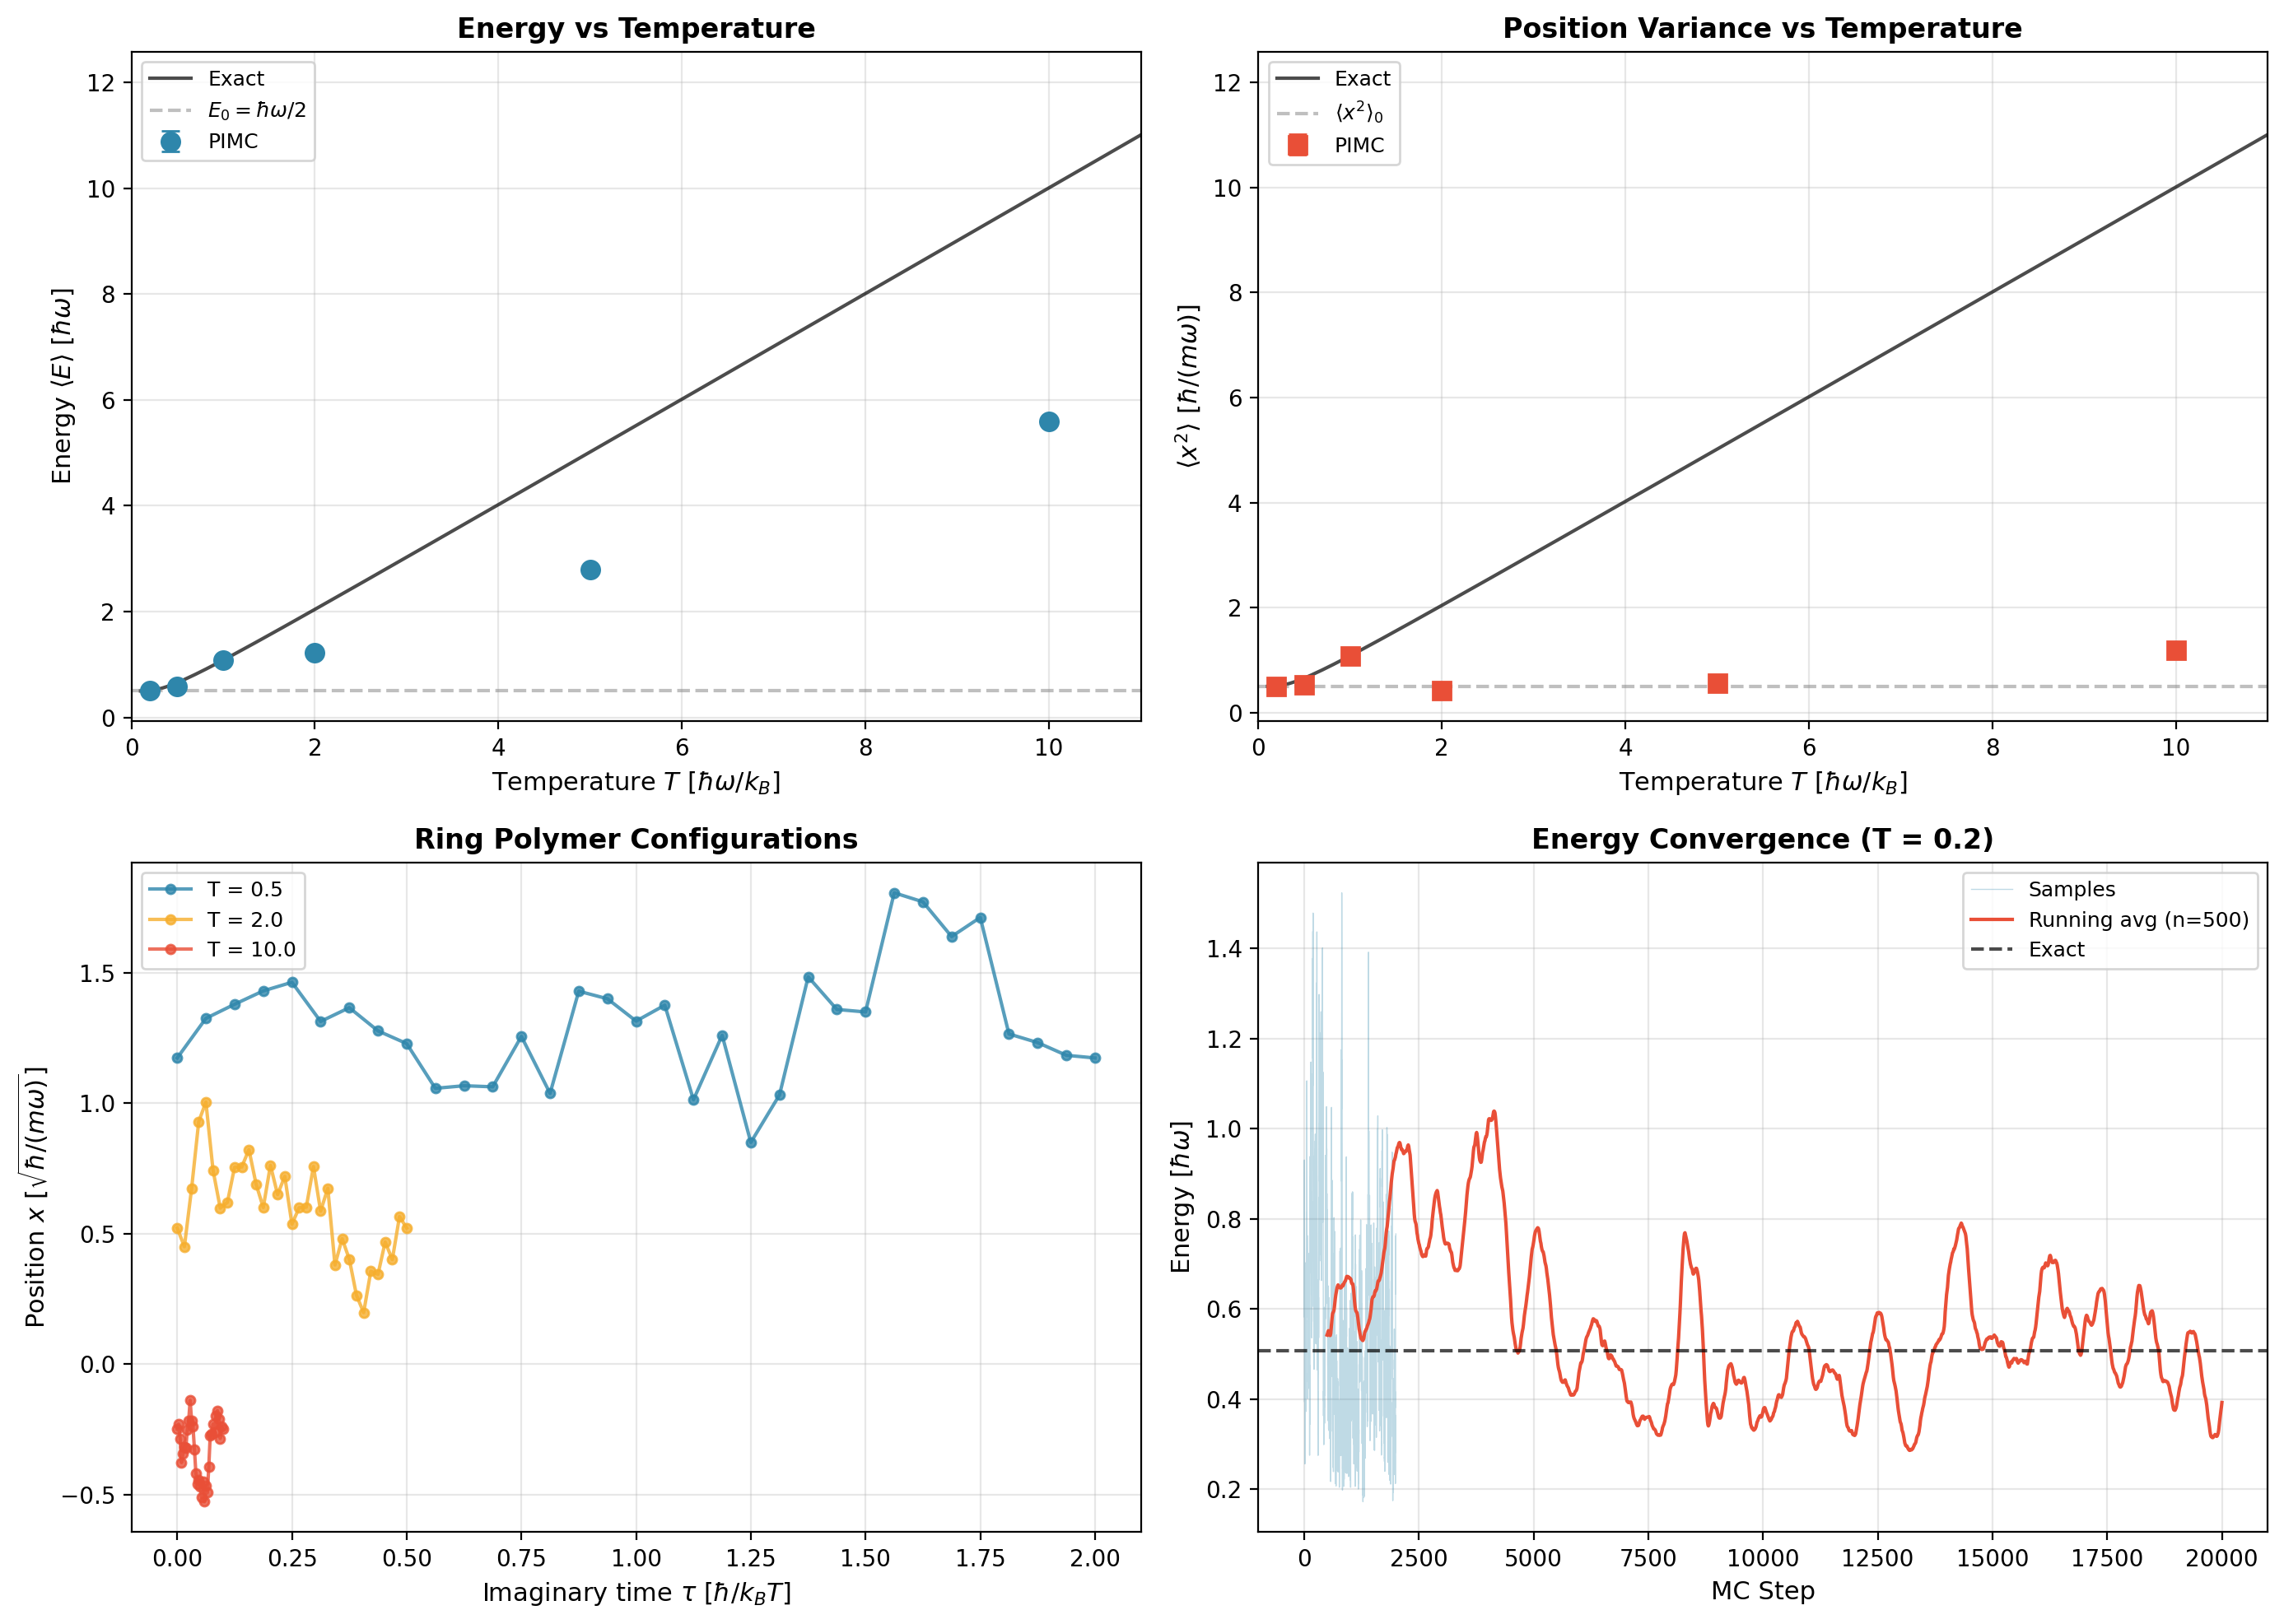


Figure saved to 'plot.png'


In [6]:
# Create comprehensive figure
fig = plt.figure(figsize=(14, 10))

# Plot 1: Energy vs Temperature
ax1 = fig.add_subplot(2, 2, 1)
E_pimc = [r['E_mean'] for r in results]
E_err = [r['E_err'] for r in results]
T_fine = np.linspace(0.1, 12, 200)
E_exact_curve = [exact_energy(1/T) for T in T_fine]

ax1.errorbar(temperatures, E_pimc, yerr=E_err, fmt='o', markersize=8, 
             capsize=4, label='PIMC', color='#2E86AB')
ax1.plot(T_fine, E_exact_curve, 'k-', linewidth=1.5, label='Exact', alpha=0.7)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label=r'$E_0 = \hbar\omega/2$')
ax1.set_xlabel(r'Temperature $T$ [$\hbar\omega/k_B$]', fontsize=11)
ax1.set_ylabel(r'Energy $\langle E \rangle$ [$\hbar\omega$]', fontsize=11)
ax1.set_title('Energy vs Temperature', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 11)

# Plot 2: Position variance vs Temperature
ax2 = fig.add_subplot(2, 2, 2)
x2_pimc = [r['x2_mean'] for r in results]
x2_err = [r['x2_err'] for r in results]
x2_exact_curve = [exact_x_squared(1/T) for T in T_fine]

ax2.errorbar(temperatures, x2_pimc, yerr=x2_err, fmt='s', markersize=8,
             capsize=4, label='PIMC', color='#E94F37')
ax2.plot(T_fine, x2_exact_curve, 'k-', linewidth=1.5, label='Exact', alpha=0.7)
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label=r'$\langle x^2 \rangle_0$')
ax2.set_xlabel(r'Temperature $T$ [$\hbar\omega/k_B$]', fontsize=11)
ax2.set_ylabel(r'$\langle x^2 \rangle$ [$\hbar/(m\omega)$]', fontsize=11)
ax2.set_title('Position Variance vs Temperature', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 11)

# Plot 3: Ring polymer configurations at different temperatures
ax3 = fig.add_subplot(2, 2, 3)

# Run short simulations to get representative paths
temps_to_show = [0.5, 2.0, 10.0]
colors = ['#2E86AB', '#F6AE2D', '#E94F37']

for T, color in zip(temps_to_show, colors):
    beta = 1.0 / T
    delta = min(1.0, np.sqrt(2 * hbar * beta / (m * M)))
    result = pimc_simulation(beta, M, 10000, 2000, delta)
    path = result['path']
    
    # Plot as ring polymer
    tau_values = np.linspace(0, beta, M, endpoint=False)
    # Close the ring
    tau_extended = np.append(tau_values, beta)
    path_extended = np.append(path, path[0])
    
    ax3.plot(tau_extended, path_extended, 'o-', markersize=4, 
             label=f'T = {T}', color=color, alpha=0.8)

ax3.set_xlabel(r'Imaginary time $\tau$ [$\hbar/k_BT$]', fontsize=11)
ax3.set_ylabel(r'Position $x$ [$\sqrt{\hbar/(m\omega)}$]', fontsize=11)
ax3.set_title('Ring Polymer Configurations', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Energy time series (convergence check)
ax4 = fig.add_subplot(2, 2, 4)

# Use low temperature result for better visualization
beta_low = 5.0
result_low = pimc_simulation(beta_low, M, 20000, 2000, 0.3)
energies = result_low['energies']

# Plot running average
window = 500
running_avg = np.convolve(energies, np.ones(window)/window, mode='valid')

ax4.plot(energies[::10], alpha=0.3, color='#2E86AB', linewidth=0.5, label='Samples')
ax4.plot(np.arange(window-1, len(energies))[::10], running_avg[::10], 
         color='#E94F37', linewidth=1.5, label=f'Running avg (n={window})')
ax4.axhline(y=exact_energy(beta_low), color='k', linestyle='--', 
            linewidth=1.5, label='Exact', alpha=0.7)
ax4.set_xlabel('MC Step', fontsize=11)
ax4.set_ylabel(r'Energy [$\hbar\omega$]', fontsize=11)
ax4.set_title(f'Energy Convergence (T = {1/beta_low:.1f})', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('path_integral_monte_carlo_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Discussion

### Key Observations

1. **Quantum-Classical Crossover**: At high temperatures ($k_BT \gg \hbar\omega$), the energy approaches the classical equipartition value $\langle E \rangle = k_BT$. At low temperatures, quantum effects dominate and $\langle E \rangle \to E_0 = \hbar\omega/2$.

2. **Ring Polymer Interpretation**: The quantum particle at inverse temperature $\beta$ maps to a classical ring polymer with $M$ beads. At low temperature (large $\beta$), the polymer spreads out, reflecting quantum delocalization (zero-point motion).

3. **Trotter Error**: The systematic error from the Trotter decomposition is $O(\tau^2) = O(\beta^2/M^2)$. Increasing $M$ reduces this error but increases computational cost.

4. **Ergodicity**: Single-bead Metropolis moves can suffer from slow sampling at low temperatures. Advanced techniques like staging or multi-level sampling improve efficiency.

### Extensions

- **Anharmonic potentials**: Double-well, quartic oscillators
- **Many-body systems**: Interacting particles, superfluidity
- **Bosonic/Fermionic statistics**: Permutation sampling for indistinguishable particles
- **Real-time dynamics**: Analytic continuation (challenging due to sign problem)

### References

1. D.M. Ceperley, "Path integrals in the theory of condensed helium," Rev. Mod. Phys. 67, 279 (1995)
2. M.E.J. Newman and G.T. Barkema, "Monte Carlo Methods in Statistical Physics" (Oxford, 1999)
3. R.P. Feynman and A.R. Hibbs, "Quantum Mechanics and Path Integrals" (McGraw-Hill, 1965)